# LM generated text detection

In [1]:
!pip install transformers tokenizers datasets

     |████████████████████████████████| 3.5 MB 5.3 MB/s 
     |████████████████████████████████| 6.8 MB 30.2 MB/s 
     |████████████████████████████████| 311 kB 48.3 MB/s 
     |████████████████████████████████| 895 kB 43.6 MB/s 
     |████████████████████████████████| 596 kB 43.8 MB/s 
     |████████████████████████████████| 67 kB 4.8 MB/s 
     |████████████████████████████████| 243 kB 48.0 MB/s 
     |████████████████████████████████| 1.1 MB 36.9 MB/s 
     |████████████████████████████████| 133 kB 36.1 MB/s 
     |████████████████████████████████| 94 kB 1.3 MB/s 
     |████████████████████████████████| 144 kB 37.4 MB/s 
     |████████████████████████████████| 271 kB 37.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import pandas as pd
import numpy as np
import torch
import pickle
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Colab\ Notebooks/kaggle/ruatd

/content/drive/MyDrive/Colab Notebooks/kaggle/ruatd


# Dataset

In [ ]:
df_train = pd.read_csv('train.csv')
df_val = pd.read_csv('val.csv')

In [ ]:
df_val.loc[df_val['Class'] == 'M', 'label'] = 0
df_val.loc[df_val['Class'] == 'H', 'label'] = 1
df_val = df_val.convert_dtypes()
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21511 entries, 0 to 21510
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      21511 non-null  Int64 
 1   Text    21511 non-null  string
 2   Class   21511 non-null  string
 3   label   21511 non-null  Int64 
dtypes: Int64(2), string(2)
memory usage: 714.4 KB


In [ ]:
df_train.loc[df_train['Class'] == 'M', 'label'] = 0
df_train.loc[df_train['Class'] == 'H', 'label'] = 1
df_train = df_train.convert_dtypes()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129066 entries, 0 to 129065
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Id      129066 non-null  Int64 
 1   Text    129066 non-null  string
 2   Class   129066 non-null  string
 3   len     129066 non-null  Int64 
 4   label   129066 non-null  Int64 
dtypes: Int64(3), string(2)
memory usage: 5.3 MB


# GLTR

In [ ]:
from scipy import stats
from transformers import (AutoTokenizer, AutoModelForCausalLM)
from tokenizers.decoders import ByteLevel

In [ ]:
def top_k_logits(logits, k):
    """
    Filters logits to only the top k choices
    from https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/examples/run_gpt2.py
    """
    if k == 0:
        return logits
    values, _ = torch.topk(logits, k)
    min_values = values[:, -1]
    return torch.where(logits < min_values,
                       torch.ones_like(logits, dtype=logits.dtype) * -1e10,
                       logits)

In [ ]:
class AbstractLanguageChecker:
    """
    Abstract Class that defines the Backend API of GLTR.

    To extend the GLTR interface, you need to inherit this and
    fill in the defined functions.
    """

    def __init__(self):
        """
        In the subclass, you need to load all necessary components
        for the other functions.
        Typically, this will comprise a tokenizer and a model.
        """
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")

    def check_probabilities(self, in_text, topk=40):
        """
        Function that GLTR interacts with to check the probabilities of words

        Params:
        - in_text: str -- The text that you want to check
        - topk: int -- Your desired truncation of the head of the distribution

        Output:
        - payload: dict -- The wrapper for results in this function, described below

        Payload values
        ==============
        bpe_strings: list of str -- Each individual token in the text
        real_topk: list of tuples -- (ranking, prob) of each token
        pred_topk: list of list of tuple -- (word, prob) for all topk
        """
        raise NotImplementedError

    def postprocess(self, token):
        """
        clean up the tokens from any special chars and encode
        leading space by UTF-8 code '\u0120', linebreak with UTF-8 code 266 '\u010A'
        :param token:  str -- raw token text
        :return: str -- cleaned and re-encoded token text
        """
        raise NotImplementedError




In [ ]:
class RuLM(AbstractLanguageChecker):
    def __init__(self, model_name_or_path="sberbank-ai/rugpt3small_based_on_gpt2"):
        super(RuLM, self).__init__()
        self.enc = AutoTokenizer.from_pretrained(model_name_or_path)
        self.enc.add_special_tokens({'bos_token': '<s>'})

        self.model = AutoModelForCausalLM.from_pretrained(model_name_or_path)
        self.model.resize_token_embeddings(len(self.enc))
        print("Device:", self.device)
        self.model.to(self.device)
        self.model.eval()
        self.start_token = self.enc('<s>', return_tensors='pt').data['input_ids'][0]
        self.decoder = ByteLevel()
        # self.start_token = self.enc.eos_token_id
        print("Loaded GPT-3 model!")

    def check_probabilities(self, in_text, topk=40):
        # Process input
        token_ids = self.enc(in_text, return_tensors='pt').data['input_ids'][0]
        token_ids = torch.concat([self.start_token, token_ids])
        # Forward through the model
        output = self.model(token_ids.to(self.device))
        all_logits = output.logits[:-1].detach().squeeze()
        # construct target and pred
        # yhat = torch.softmax(logits[0, :-1], dim=-1)
        all_probs = torch.softmax(all_logits, dim=1)

        y = token_ids[1:]
        # Sort the predictions for each timestep
        sorted_preds = torch.argsort(all_probs, dim=1, descending=True).cpu()
        # [(pos, prob), ...]
        real_topk_pos = list(
            [int(np.where(sorted_preds[i] == y[i].item())[0][0])
             for i in range(y.shape[0])])
        real_topk_probs = all_probs[np.arange(0, y.shape[0], 1), y].data.cpu().numpy().tolist()
        real_topk_probs = list(map(lambda x: round(x, 5), real_topk_probs))

        real_topk = list(zip(real_topk_pos, real_topk_probs))
        # [str, str, ...]
        bpe_strings = [self.decoder.decode([self.enc.convert_ids_to_tokens(tok.item())]) for tok in token_ids[:]]

        bpe_strings = [self.postprocess(s) for s in bpe_strings]

        topk_prob_values, topk_prob_inds = torch.topk(all_probs, k=topk, dim=1)

        pred_topk = [list(zip([self.decoder.decode(self.enc.convert_ids_to_tokens(tok.item())) for tok in topk_prob_inds[i]] ,
                              topk_prob_values[i].data.cpu().numpy().tolist()
                              )) for i in range(y.shape[0])]
        pred_topk = [[(self.postprocess(t[0]), t[1]) for t in pred] for pred in pred_topk]


        # pred_topk = []
        payload = {'bpe_strings': bpe_strings,
                   'real_topk': real_topk,
                   'pred_topk': pred_topk}
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        return payload

    def sample_unconditional(self, length=100, topk=5, temperature=1.0):
        '''
        Sample `length` words from the model.
        Code strongly inspired by
        https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/examples/run_gpt2.py

        '''
        context = torch.full((1, 1),
                             self.enc.encoder['<s>'],
                             device=self.device,
                             dtype=torch.long)
        prev = context
        output = context
        # Forward through the model
        with torch.no_grad():
            for i in range(length):
                logits = self.model(prev).logits
                logits = logits[:, -1, :] / temperature
                # Filter predictions to topk and softmax
                probs = torch.softmax(top_k_logits(logits, k=topk),
                                      dim=-1)
                # Sample
                prev = torch.multinomial(probs, num_samples=1)
                # Construct output
                output = torch.cat((output, prev), dim=1)

        output_text = self.enc.decode(output[0].tolist())
        return output_text

    def postprocess(self, token):
        with_space = False
        with_break = False
        if token.startswith('Ġ'):
            with_space = True
            token = token[1:]
            # print(token)
        elif token.startswith('â'):
            token = ' '
        elif token.startswith('Ċ'):
            token = ' '
            with_break = True

        token = '-' if token.startswith('â') else token
        token = '“' if token.startswith('ľ') else token
        token = '”' if token.startswith('Ŀ') else token
        token = "'" if token.startswith('Ļ') else token

        if with_space:
            token = '\u0120' + token
        if with_break:
            token = '\u010A' + token

        return token

In [ ]:
def real_topk_count(payload: dict) -> dict:    
    ids = np.array([x[0] for x in payload['real_topk']])
    topk_10 = ids[ids < 10]
    topk_100 = ids[np.where(np.logical_and(ids >= 10, ids < 100))]
    topk_1000 = ids[np.where(np.logical_and(ids >= 100, ids < 1000))]
    topk_over_1000 = ids[ids > 1000]

    frac_p = [payload['real_topk'][i][1] / np.max([x[1] for x in payload['pred_topk'][i]]) for i in range(len(payload['real_topk']))]

    threshold = 10
    pred_probs_normal = [[ x[1] for x in payload['pred_topk'][i][:threshold] ] for i in range(len(payload['pred_topk']))] 
    pred_probs_normal = [[y / sum(x) for y in x] for x in pred_probs_normal]  
    frac_entr = stats.entropy(pred_probs_normal, axis=1)

    return {'topk_10': np.round(len(topk_10) / len(ids), 4),
            'topk_100': np.round(len(topk_100) / len(ids), 4),
            'topk_1000': np.round(len(topk_1000) / len(ids), 4),
            'topk_over_1000': np.round(len(topk_over_1000) / len(ids), 4),
            'frac_p_median': np.round(np.median(frac_p), 4),
            'frac_entr_median': np.round(np.median(frac_entr), 4),
            'tokens_size': len(ids)}

In [ ]:
idx_limit = 10000
df_train_limited = pd.concat([df_train[df_train['Class'] == 'M'][:idx_limit], df_train[df_train['Class'] == 'H'][:idx_limit]])

In [ ]:
lm = RuLM()
train_payload = []
for raw_text in tqdm(df_train_limited['Text']):
    payload = lm.check_probabilities(raw_text, topk=20)
    train_payload.append(payload)

In [ ]:
with open('train_payload.pkl', 'wb') as f:    
    pickle.dump(train_payload, f)

In [ ]:
with open('train_payload.pkl', 'rb') as f:    
    new_train_payload = pickle.load(f)

In [ ]:
print(len(new_train_payload))

In [ ]:
df_topk = pd.DataFrame.from_dict([real_topk_count(payload) for payload in tqdm(new_train_payload)])

In [ ]:
df_train_limited.reset_index(drop=True, inplace=True)

In [ ]:
df_train_topk = pd.DataFrame.join(df_train_limited, df_topk)

In [ ]:
df_train_topk.to_pickle('df_train_topk.pkl')

In [ ]:
df_new = pd.read_pickle('df_train_topk.pkl') 

In [ ]:
df_new.info()

# Classic ML

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## LogReg

In [ ]:
df_new.loc[:,'topk_10':'tokens_size'].head()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_new.loc[:,'topk_10':'tokens_size'], df_new['Class'], test_size=0.1)

In [ ]:
encoder = LabelEncoder()
encoder.fit(y_train)

In [ ]:
y_train_enc = encoder.transform(y_train)
y_test_enc = encoder.transform(y_test)

In [ ]:
clf = LogisticRegression()
clf.fit(x_train, y_train_enc)

In [ ]:
y_test_pred = clf.predict(x_test)

In [ ]:
y_train_pred = clf.predict(x_train)

In [ ]:
print(classification_report(y_train_enc, y_train_pred))

In [ ]:
print(classification_report(y_test_enc, y_test_pred))
print(confusion_matrix(y_test_enc, y_test_pred))

## SVC

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
x_train['tokens_size'] = scaler.fit_transform(x_train['tokens_size'].to_numpy().reshape(-1, 1))

In [ ]:
clf_svc = LinearSVC(max_iter=10000)
clf_svc.fit(x_train, y_train_enc)

In [ ]:
y_pred = clf_svc.predict(x_train)
print(classification_report(y_train_enc, y_pred))

# Feature Extraction

In [ ]:
# TO DO

# BERT

In [16]:
from transformers import (AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, EarlyStoppingCallback, AutoConfig)
from datasets import Dataset, load_metric, Features, ClassLabel, Value

In [ ]:
del bert
del training_args
del trainer
torch.cuda.empty_cache()

In [ ]:
# model_name = "DeepPavlov/rubert-base-cased-sentence"
model_name = "DeepPavlov/rubert-base-cased"
# model_name = 'cointegrated/rubert-tiny'
num_labels = 2
batch_size = 24
epochs = 3
lr=2e-5
max_len=200

In [ ]:
tokenizer_bert = AutoTokenizer.from_pretrained(model_name)

In [ ]:
df_val['len'] = df_val['Text'].map(lambda x: len(tokenizer_bert(x)['input_ids'])) 
df_train['len'] = df_train['Text'].map(lambda x: len(tokenizer_bert(x)['input_ids'])) 

In [ ]:
print(df_val['len'].describe())
print(df_train['len'].describe())

count    21511.000000
mean        46.994050
std         77.162579
min          6.000000
25%         14.000000
50%         21.000000
75%         34.000000
max        790.000000
Name: len, dtype: float64
count    129066.000000
mean         46.968946
std          77.071282
min           5.000000
25%          14.000000
50%          21.000000
75%          34.000000
max         852.000000
Name: len, dtype: float64


<AxesSubplot:ylabel='Frequency'>

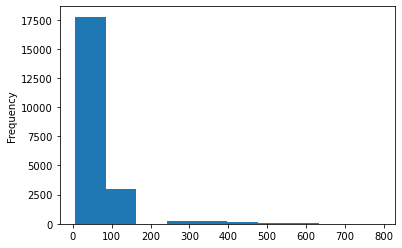

In [ ]:
df_val['len'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

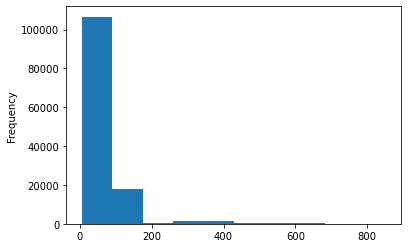

In [ ]:
df_train['len'].plot.hist()

In [17]:
def build_dataset(data: pd.DataFrame, tokenizer: AutoTokenizer, max_length=512, with_label=True):
    if with_label:
        class_names = ["M", "H"]
        features = Features({'Text': Value('string'), 'label': ClassLabel(names=class_names, num_classes=2)})
        dataset = Dataset.from_pandas(data, preserve_index=False, features=features)
        dataset = dataset.map(lambda e: tokenizer(e['Text'], truncation=True, padding='max_length', max_length=max_length), batched=True)    
        dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
    else:
        dataset = Dataset.from_pandas(data, preserve_index=False)
        dataset = dataset.map(lambda e: tokenizer(e['Text'], truncation=True, padding='max_length', max_length=max_length), batched=True)    
        dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask'])
    return dataset

In [ ]:
ds_val = build_dataset(df_val, tokenizer_bert, max_length=max_len)

100%|██████████| 22/22 [00:03<00:00,  5.92ba/s]


In [ ]:
ds_train = build_dataset(df_train, tokenizer_bert, max_length=max_len)

100%|██████████| 130/130 [00:23<00:00,  5.53ba/s]


In [ ]:
config_bert = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels)

bert = AutoModelForSequenceClassification.from_pretrained(model_name, config=config_bert)

In [ ]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments("test_trainer", 
                                per_device_train_batch_size=batch_size, 
                                per_device_eval_batch_size=batch_size,
                                num_train_epochs=epochs,
                                learning_rate=lr,
                                save_strategy='epoch',
                                evaluation_strategy='epoch',
                                save_total_limit=2,
                                load_best_model_at_end=True,
                                do_train=True,
                                do_eval=True,
                                optim='adamw_torch',
                                report_to="none"
                                )

PyTorch: setting up devices


In [ ]:
!nvidia-smi

In [ ]:
trainer = Trainer(model=bert, 
                args=training_args, 
                train_dataset=ds_train, 
                eval_dataset=ds_val,
                compute_metrics=compute_metrics,
                tokenizer=tokenizer_bert, 
                callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
                )

  0%|          | 1/1009 [3:44:08<3765:39:35, 13448.79s/it]


In [ ]:
train_result = trainer.train()

In [ ]:
metrics = train_result.metrics

# Evaluate

In [6]:
!cp /content/drive/MyDrive/models/out.7z /content

In [ ]:
!7z x /content/out.7z

In [14]:
df_test = pd.read_csv('test.csv')

In [ ]:
df_test['len'] = df_test['Text'].map(lambda x: len(tokenizer_bert(x)['input_ids'])) 

<AxesSubplot:ylabel='Frequency'>

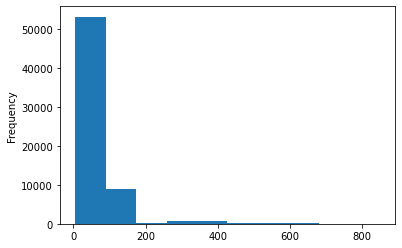

In [ ]:
df_test['len'].plot.hist()

In [19]:
cp_path = 'test_trainer/checkpoint-8068'

In [20]:
model_loaded = AutoModelForSequenceClassification.from_pretrained(cp_path)
tokenizer_loaded = AutoTokenizer.from_pretrained(cp_path)

In [22]:
ds_test = build_dataset(df_test, tokenizer_loaded, max_length=200, with_label=False)

  0%|          | 0/65 [00:00<?, ?ba/s]

In [24]:
training_args = TrainingArguments("eval_trainer", 
                                per_device_train_batch_size=64, 
                                per_device_eval_batch_size=64,
                                do_train=False,
                                do_eval=False,
                                report_to="none"
                                )

In [25]:
trainer = Trainer(model=model_loaded, 
                    args=training_args)
predictions = trainer.predict(ds_test).predictions

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Id, Text.
***** Running Prediction *****
  Num examples = 64533
  Batch size = 64


In [26]:
predictions = np.argmax(predictions, axis=1) 

In [27]:
df_test['label'] = predictions

In [28]:
df_test.loc[df_test['label'] == 0, 'Class'] = 'M'
df_test.loc[df_test['label'] == 1, 'Class'] = 'H'

In [29]:
df_test.to_csv('submission.csv', columns=['Id','Class'], index=False) 